=== LightGBM Forecast ===
customer_code=4721108, product_code=130049
予測先日数 (forecast_offset) = 3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27566
[LightGBM] [Info] Number of data points in the train set: 3746, number of used features: 294
[LightGBM] [Info] Start training from score 0.571822


/var/folders/dt/1m9_rs4d1_1g57kgnn99l1qr0000gn/T/ipykernel_74057/484554409.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


★ MSE (offset=3): 259.879


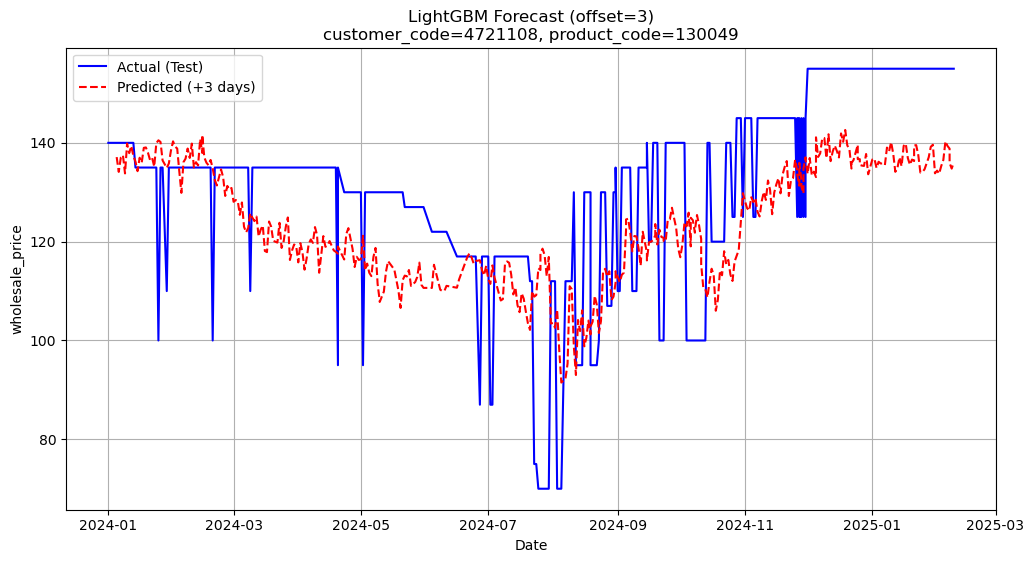

=== LightGBM Forecast ===
customer_code=4721108, product_code=130049
予測先日数 (forecast_offset) = 14
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26526
[LightGBM] [Info] Number of data points in the train set: 3735, number of used features: 266
[LightGBM] [Info] Start training from score 0.571528


/var/folders/dt/1m9_rs4d1_1g57kgnn99l1qr0000gn/T/ipykernel_74057/484554409.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


★ MSE (offset=14): 260.046


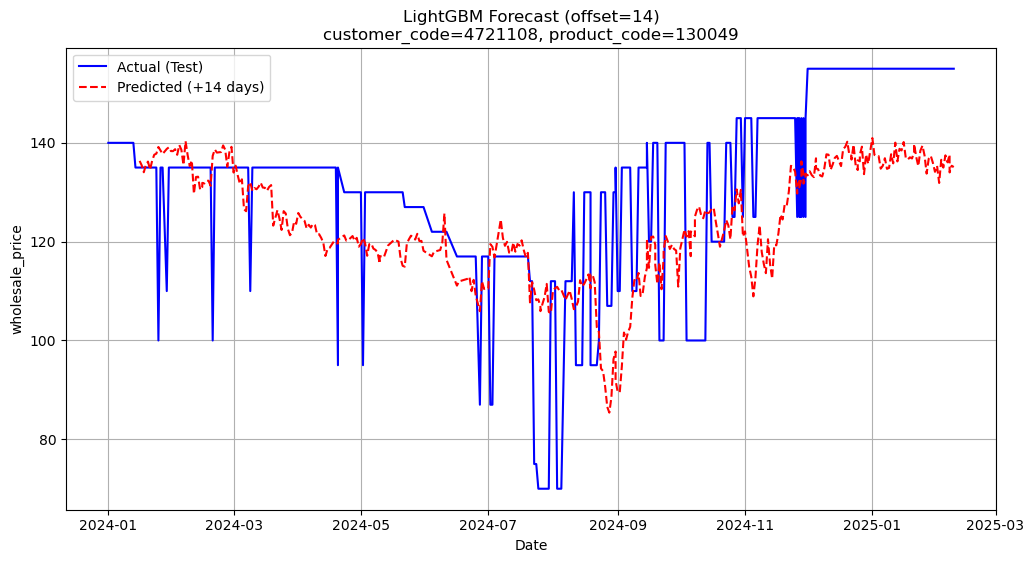

=== LightGBM Forecast ===
customer_code=4721108, product_code=130049
予測先日数 (forecast_offset) = 30
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26044
[LightGBM] [Info] Number of data points in the train set: 3719, number of used features: 252
[LightGBM] [Info] Start training from score 0.570999


/var/folders/dt/1m9_rs4d1_1g57kgnn99l1qr0000gn/T/ipykernel_74057/484554409.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


★ MSE (offset=30): 380.870


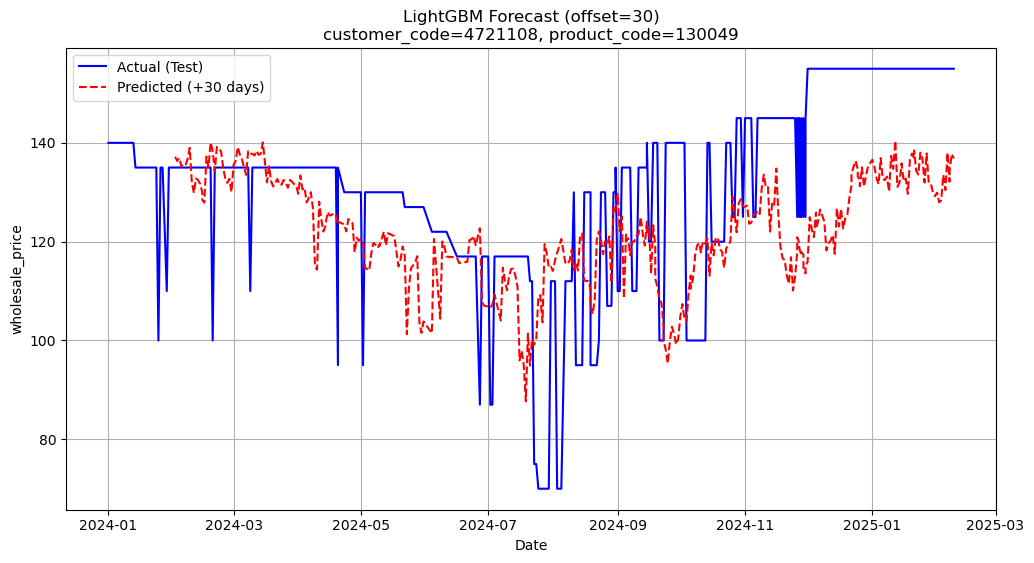

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor

def create_two_types_of_lags(df: pd.DataFrame, forecast_offset: int):
    """
    ラグを2種類作成する:
      1) 「予測を行う日 (T)」基準のラグ:  lag_{l}_T
         => 常に T-l 日前の値 (標準的なラグ)
      2) 「予測先の日 (T+offset)」基準のラグ: lag_{l}_pred
         => T+offset-l
         => もし offset >= l なら T+offset-l >= T → 未来なのでリーク => 作らない
         => もし offset <  l なら T+offset-l < T → 過去なので作る
    """

    # ラグ候補
    candidate_lags = [1, 2, 3, 7, 14, 30, 365]

    # 1) 予測を行う日 (T) 基準 => lag_{l}_T
    for l in candidate_lags:
        df[f'lag_{l}_T'] = df['wholesale_price'].shift(l)

    # 2) 予測先の日 (T+offset) 基準 => lag_{l}_pred
    #    => offset < l なら作成, offset >= l ならスキップ
    for l in candidate_lags:
        if forecast_offset < l:
            # シフト量 = l - offset (正の値)
            shift_val = l - forecast_offset
            df[f'lag_{l}_pred'] = df['wholesale_price'].shift(shift_val)

    return df

def create_full_features(df: pd.DataFrame, forecast_offset: int) -> pd.DataFrame:
    """
    - shipment_date を datetime 化 & ソート & インデックス化
    - 基本的なカレンダー・ローリング特徴量などを作成
    - 最後に create_two_types_of_lags() を呼んで2種類のラグを追加
    """
    df['shipment_date'] = pd.to_datetime(df['shipment_date'].astype(str), format='%Y%m%d', errors='coerce')
    df = df.sort_values('shipment_date').reset_index(drop=True)
    df.set_index('shipment_date', inplace=True)

    # 例: 基本カレンダー特徴量
    df['year']        = df.index.year
    # df['month']       = df.index.month--不要
    df['day']         = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear

    # ローリング例
    df['rolling_mean_7'] = df['wholesale_price'].rolling(7).mean()
    df['rolling_std_7']  = df['wholesale_price'].rolling(7).std()
    df['rolling_mean_14'] = df['wholesale_price'].rolling(14).mean()
    df['rolling_std_14']  = df['wholesale_price'].rolling(14).std()
    # 差分例
    #df['diff_1'] = df['wholesale_price'].diff()--不要

    # 2種類のラグを追加
    df = create_two_types_of_lags(df, forecast_offset)

    # 欠損埋め
    df.fillna(method='bfill', inplace=True)

    return df

def create_sequences(array_2d: np.ndarray, lookback: int, forecast_offset: int):
    """
    過去 lookback 日分を入力, lookback+forecast_offset 番目のwholesale_priceをターゲット
    """
    X, y = [], []
    target_offset = lookback + forecast_offset
    for i in range(len(array_2d) - target_offset):
        X.append(array_2d[i:i+lookback, :])
        y.append(array_2d[i+target_offset, 0])  # 0列目=wholesale_price
    return np.array(X), np.array(y)

def full_feature_lgbm_forecast_evaluate(df: pd.DataFrame, customer_code, product_code,
                                        forecast_offset: int = 3) -> float:
    """
    LightGBM で時系列予測 (ローリング予測)。
    予測先日数 = forecast_offset。
    create_full_features() で 2種類のラグを作る:
      - lag_{l}_T (当日基準)
      - lag_{l}_pred (予測先日基準; offset<l の場合のみ)
    """
    print(f"=== LightGBM Forecast ===")
    print(f"customer_code={customer_code}, product_code={product_code}")
    print(f"予測先日数 (forecast_offset) = {forecast_offset}")

    # 1) フィルタ
    df_filtered = df[
        (df['customer_code'].astype(str) == str(customer_code)) &
        (df['product_code'].astype(str) == str(product_code))
    ].copy()
    if df_filtered.empty:
        print("★ 該当データがありません。終了。")
        return np.nan

    # 2) 特徴量作成 (2種類のラグ含む)
    df_features = create_full_features(df_filtered, forecast_offset)

    # ターゲットを先頭に
    cols = ['wholesale_price'] + [c for c in df_features.columns if c != 'wholesale_price']
    df_features = df_features[cols]

    # 3) 学習 & テスト分割
    train = df_features[df_features.index < '2024-01-01']
    test  = df_features[df_features.index >= '2024-01-01']
    if len(train) < 30 or len(test) == 0:
        print("★ 学習 or テストデータ不足")
        return np.nan

    # 4) スケーリング
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train)
    test_scaled  = scaler.transform(test)

    # 5) シーケンス
    lookback = 14
    X_train_3d, y_train = create_sequences(train_scaled, lookback, forecast_offset)
    n_samples, n_lookback, n_features = X_train_3d.shape
    X_train_2d = X_train_3d.reshape(n_samples, n_lookback*n_features)

    # 6) 学習 (LightGBM)
    model = LGBMRegressor(n_estimators=1000, learning_rate=0.01, random_state=42)
    model.fit(X_train_2d, y_train)

    # 7) テストのローリング予測
    test_values = test['wholesale_price'].values
    n_test = test_scaled.shape[0]
    history_array = np.concatenate([train_scaled[-(lookback+forecast_offset):], test_scaled], axis=0)
    forecast_values = []

    for i in range(n_test - forecast_offset):
        x_input_3d = history_array[i : i+lookback, :]
        x_input_2d = x_input_3d.reshape(1, -1)
        pred = model.predict(x_input_2d)[0]
        forecast_values.append(pred)

        # 予測を 0列目(wholesale_price) に反映
        if (i+lookback+forecast_offset) < len(history_array):
            history_array[i+lookback+forecast_offset, 0] = pred

    forecast_values = np.array(forecast_values).reshape(-1, 1)

    # 8) 逆正規化
    dummy = np.zeros((forecast_values.shape[0], df_features.shape[1]))
    dummy[:, 0] = forecast_values[:, 0]
    inv_forecast = scaler.inverse_transform(dummy)[:, 0]

    # 9) MSE
    test_values_clip = test_values[:len(inv_forecast)]
    mse = mean_squared_error(test_values_clip, inv_forecast)
    print(f"★ MSE (offset={forecast_offset}): {mse:.3f}")

    # 10) 可視化
    plt.figure(figsize=(12,6))
    test_idx = test.index
    n_pred = len(inv_forecast)
    pred_index = test_idx[forecast_offset : forecast_offset + n_pred]

    plt.plot(test_idx, test_values, label="Actual (Test)", color='blue')
    plt.plot(pred_index, inv_forecast, label=f"Predicted (+{forecast_offset} days)", linestyle='--', color='red')
    plt.title(f"LightGBM Forecast (offset={forecast_offset})\ncustomer_code={customer_code}, product_code={product_code}")
    plt.xlabel("Date")
    plt.ylabel("wholesale_price")
    plt.legend()
    plt.grid()
    plt.show()

    return mse

# --- 使用例 ---
if __name__ == "__main__":
    df = pd.read_csv("../Input/product_code=130049_customer_code=4721108.csv")
    # 3日後
    mse_3 = full_feature_lgbm_forecast_evaluate(df, 4721108, 130049, forecast_offset=3)
    # 14日後
    mse_14 = full_feature_lgbm_forecast_evaluate(df, 4721108, 130049, forecast_offset=14)
    # 30日後
    mse_30 = full_feature_lgbm_forecast_evaluate(df, 4721108, 130049, forecast_offset=30)


In [ ]:
333.370
292.438
320.966
295.171
291.511